# Project Ashen Vault

ML model to build it

In [52]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from pathlib import Path
from tqdm import tqdm

In [16]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Pray you are using a cuda: {device}")
if device == "cpu":
    print("gg....")

Pray you are using a cuda: cpu
gg....


In [44]:
# Important directories
data_dir = Path("data")
train_dir = Path("../data/train")
test_dir = Path("../data/test")

# print("Current Working Directory:", Path.cwd())

count of train-wildfire images: 15750
size: (350, 350, 3)


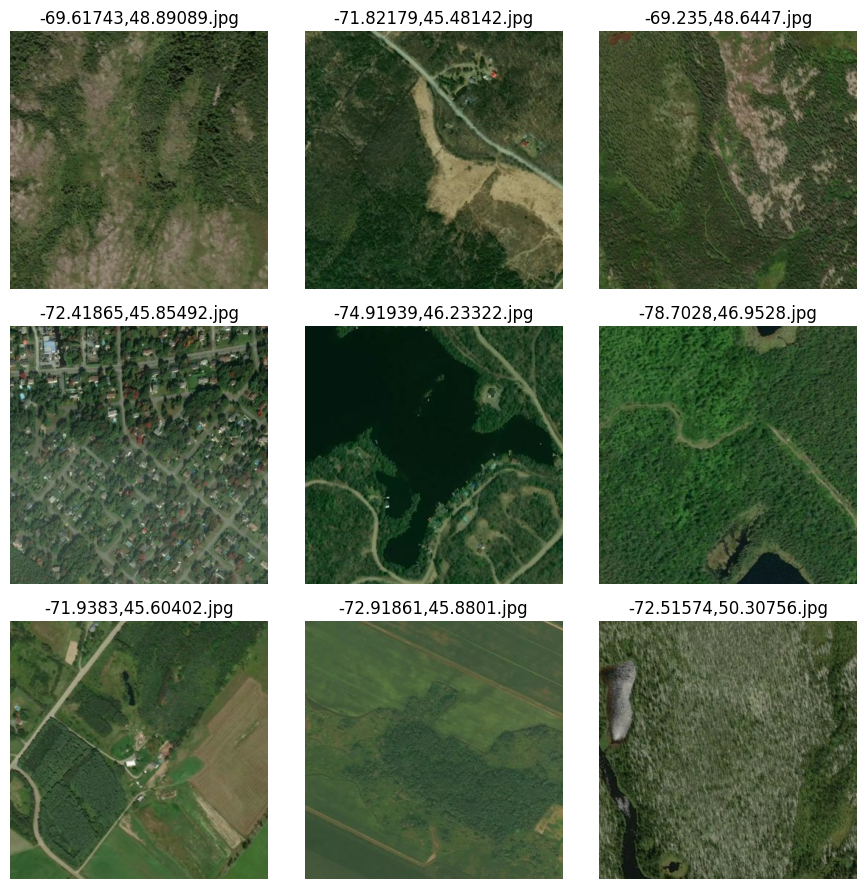

In [43]:
height = 3
width = 3
fig, axes = plt.subplots(height, width, figsize=(9, 9))
axes = axes.ravel()  # Flatten the 3x3 matrix of axes to easily loop over them

train_wildfire_dir = Path("../data/train/wildfire")
image_files = list(train_wildfire_dir.glob('*.jpg'))
print(f"count of train-wildfire images: {len(image_files)}")
first_img = Image.open(image_files[0])
first_img_size = np.array(first_img).shape

print(f"size: {first_img_size}")
np.random.shuffle(image_files) 

selected_images = image_files[:height * width]

for i, img_path in enumerate(selected_images):
    image = Image.open(img_path)
    axes[i].imshow(image)
    axes[i].set_title(os.path.basename(img_path))
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

In [62]:
# Define a custom dataset
class WildfireDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = list(directory.glob('*.jpg'))  # Adjust pattern as needed

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure image is RGB
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
# Instantiate the dataset and dataloader
dataset = WildfireDataset(train_wildfire_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [50]:
# define network model
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(16 * 64 * 64, 10)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 64 * 64)
        x = self.fc(x)
        return x

num_classes = 2
net = Net(num_classes)
print(net)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=65536, out_features=10, bias=True)
)


In [60]:
def train(train_set, net, epochs=10, batch=200, learning_rate=1e-3):

    # Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Track loss for plotting
    train_loss = []

    print("Starting training...")

    net.train()  # Set model to training mode
    epoch = 0
    for _ in tqdm(range(epochs)):
        epoch += 1
        running_loss = 0.0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(images)
            # Squeeze output to match labels shape
            loss = criterion(outputs.squeeze(), labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        train_loss.append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    print("Finished Training")

    # Optional: Plotting the training loss
    import matplotlib.pyplot as plt

    plt.plot(train_loss, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [61]:
net = Net(2).to(device)
loss, acc = train(train_set=dataloader, net=net)

Starting training...


  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)